### Steps

1. **Started with Initialization**:  
   I imported the necessary libraries for data manipulation, visualization, and machine learning. This step ensured I had all the tools required for processing the data and building models.

2. **Loaded and Inspected the Data**:  
   I loaded the NYC restaurant inspection dataset and performed an initial exploration. I looked at the first few rows, checked the data types, and identified any missing or inconsistent values that needed to be addressed.

3. **Cleaned and Preprocessed the Data**:  
   I standardized the dataset by converting key columns, like `SCORE` and `INSPECTION DATE`, into usable numeric and datetime formats. I filtered out unnecessary columns and removed rows with crucial missing values. Additionally, I standardized borough names and created a binary indicator for critical violations.

4. **Performed Exploratory Data Analysis (EDA)**:  
   I visualized the distribution of inspection scores to understand their range and frequency. I also examined borough-level performance and the relationship between cuisine types and average scores, using bar plots and histograms to identify trends and insights.

5. **Engineered Features for Modeling**:  
   I introduced a binary target variable (`HIGH_RISK`) to identify high-risk establishments based on a score threshold. Categorical variables like `BORO`, `GRADE`, and `CUISINE DESCRIPTION` were converted to numeric values using one-hot encoding. I also extracted new features, such as the year and month of inspections, to add temporal insights.

6. **Built and Evaluated a Regression Model**:  
   I trained a linear regression model to predict inspection scores. To evaluate the model, I calculated metrics like RMSE and R², which helped assess how well the model fit the data.

7. **Trained Multiple Classification Models**:  
   I compared various classifiers, including Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and SVM (took too long to train), to predict whether a restaurant was high-risk. For each model, I calculated performance metrics such as accuracy, precision, recall, and F1 score to determine their effectiveness.

8. **Visualized the Results**:  
   To interpret the performance of the regression model, I created a scatter plot of actual vs. predicted scores. For the classification models, I compared their metrics to identify the best approach for predicting high-risk restaurants.



First 5 rows of the data:


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1
0,50144421,TAIM MEDITERRANEAN KITCHEN,Manhattan,2485,BROADWAY,10025,6782210550,NaN,01/01/1900,NaN,...,NaN,40.792361357641,-73.973459221061,107,06,017900,1033611,1012400010,MN12,NaN
1,50103827,SPRINGFIELD ADULT DAY CARE LLC,Manhattan,602,EAST 12 STREET,10009,8454702131,NaN,01/01/1900,NaN,...,NaN,40.727989642702,-73.97876343192,103,02,002800,1089953,1003947507,MN28,NaN
2,50153578,MOMMY PAI'S,Manhattan,203,MOTT STREET,10012,6462794518,NaN,01/01/1900,NaN,...,NaN,40.721431530121,-73.995548192983,102,01,004100,1007182,1004800024,MN24,NaN
3,50159836,"ROMAINE EMPIRE, INC.",Manhattan,650,5TH AVE,10019,3122290099,NaN,01/01/1900,NaN,...,NaN,40.759781792897,-73.976544114914,105,04,010400,1034517,1012670041,MN17,NaN
4,50123437,FRESH STOP JUICE BAR INC,0,274,ATLANTIC AVE,11518,9176809065,NaN,01/01/1900,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262638 entries, 0 to 262637
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   CAMIS                  262638 non-null  object
 1   DBA                    262638 non-null  object
 2   BORO                   262638 non-null  object
 3   BUILDING               262263 non-null  object
 4   STREET                 262635 non-null  object
 5   ZIPCODE                259954 non-null  object
 6   PHONE                  262636 non-null  object
 7   CUISINE DESCRIPTION    259322 non-null  object
 8   INSPECTION DATE        262638 non-null  object
 9   ACTION                 259322 non-null  object
 10  VIOLATION CODE         257693 non-null  object
 11  VIOLATION DESCRIPTION  257693 non-null  object
 12  CRITICAL FLAG          262638 non-null  object
 13  SCORE                  249243 non-null  object
 14  GRADE                  125841 non-nu

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1
count,262638,262638,262638,262263,262635,259954,262636,259322,262638,259322,...,259322,262279,262279,259313,259328,259328,257975,261994,259313,0
unique,29760,23881,6,7677,2450,231,26536,89,1780,5,...,33,24048,24048,69,51,1178,20766,20434,194,0
top,40365904,DUNKIN,Manhattan,1,BROADWAY,10003,2126159700,American,01/01/1900,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,0,0,105,03,087100,4000000,1,MN17,NaN
freq,71,3228,96908,1233,9980,6087,166,42064,3316,245324,...,142809,2681,2681,19721,21233,2350,1094,1985,14766,NaN


Data after preprocessing. Shape: (249243, 9)


,BORO,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,SCORE,GRADE,GRADE DATE,INSPECTION TYPE,CRITICAL_FLAG_BINARY
7,Manhattan,American,2018-05-16,Violations were cited in the following area(s).,4.0,A,2018-05-16,Cycle Inspection / Initial Inspection,0.0
16,Brooklyn,American,2022-04-08,Violations were cited in the following area(s).,22.0,Other,NaT,Cycle Inspection / Initial Inspection,0.0
18,Queens,Pizza,2023-02-16,Violations were cited in the following area(s).,13.0,A,2023-02-16,Cycle Inspection / Re-inspection,0.0
25,Queens,Mediterranean,2021-09-04,No violations were recorded at the time of thi...,0.0,Other,NaT,Inter-Agency Task Force / Initial Inspection,0.0
42,Queens,American,2023-10-03,No violations were recorded at the time of thi...,0.0,A,2023-10-03,Cycle Inspection / Initial Inspection,0.0


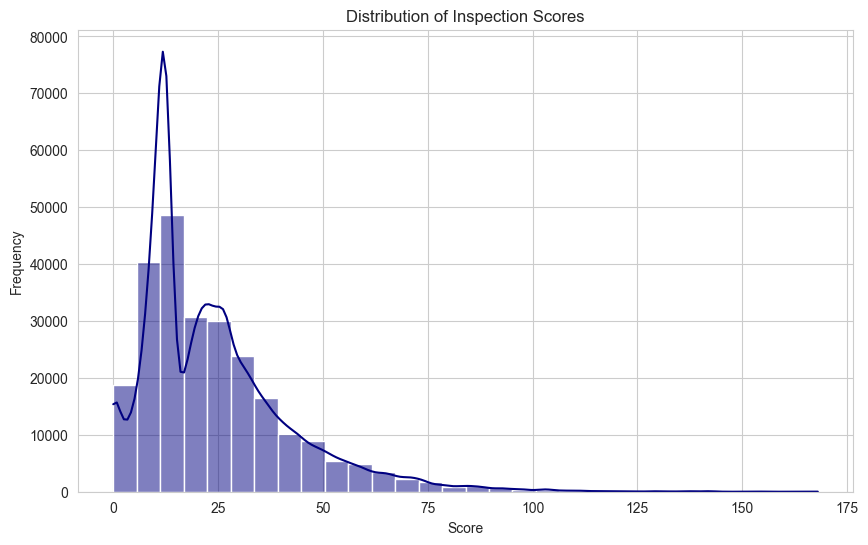

/var/folders/wd/dl2c2ls12d94l2v69kyndnt80000gn/T/ipykernel_38767/3928177291.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.barplot(x=avg_scores_boro.index, y=avg_scores_boro.values, palette='Set2')


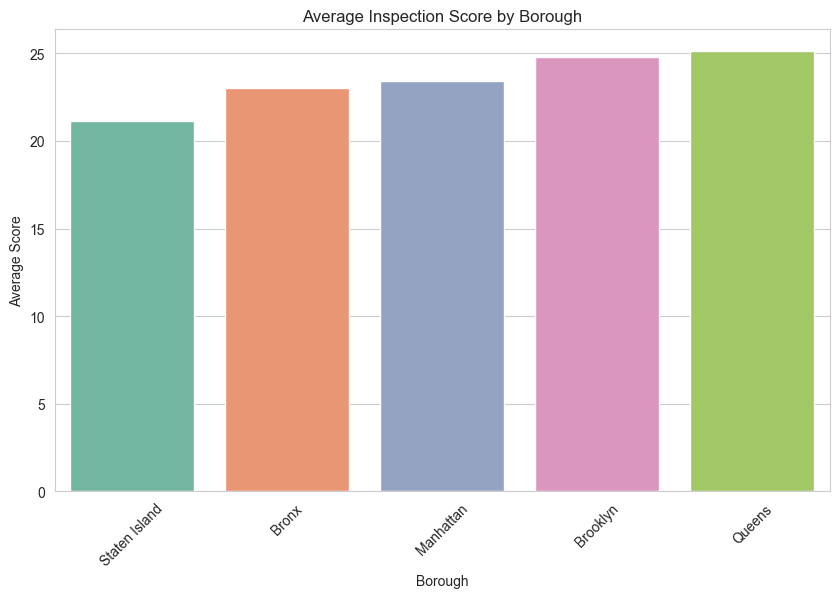

/var/folders/wd/dl2c2ls12d94l2v69kyndnt80000gn/T/ipykernel_38767/3928177291.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.barplot(x=avg_scores_cuisine.index, y=avg_scores_cuisine.values, palette='Set3')


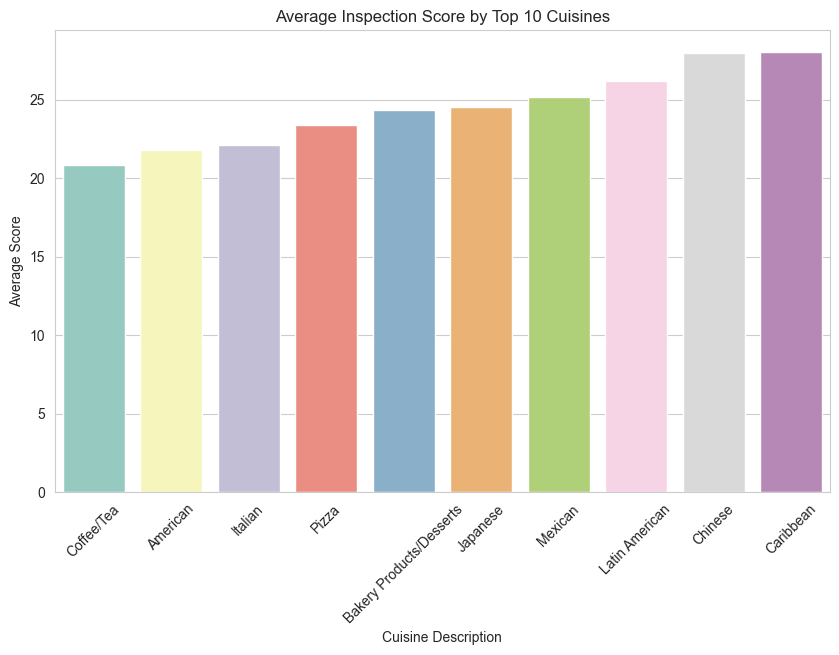

Regression Results:
RMSE: 12.68281020373189
R^2 Score: 0.5058130416615451


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Results:
Accuracy: 0.781379766896026
Precision: 0.6672922599016309
Recall: 0.6417102315160568
F1 Score: 0.654251269035533

Decision Tree Results:
Accuracy: 0.8538385925494995
Precision: 0.7750908407467736
Recall: 0.7699775952203136
F1 Score: 0.7725257571027162

Random Forest Results:
Accuracy: 0.852113382414893
Precision: 0.7627825456303639
Recall: 0.7854742345033607
F1 Score: 0.7739621021647145

Gradient Boosting Results:
Accuracy: 0.7882204256855704
Precision: 0.6733127869677338
Recall: 0.6662310181727658
F1 Score: 0.6697531829699378


In [3]:
"""sml312.ipynb

Predicting High-Risk Restaurants in NYC: A Data-Driven Approach
"""

# ## 1. Initialization
# import necessary libraries and set up the initial configurations for the analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from datetime import datetime

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, precision_score,
    recall_score, f1_score
)

# General settings
sea.set_style("whitegrid")

# ## 2. Load and Inspect Data

df = pd.read_csv('restaurant_inspections.csv', dtype=str)

print("First 5 rows of the data:")
display(df.head())

print("DataFrame Info:")
df.info()

print("DataFrame Describe:")
display(df.describe(include='all'))

# ## 3. Data Cleaning and Preprocessing
if 'SCORE' in df.columns:
    df['SCORE'] = pd.to_numeric(df['SCORE'], errors='coerce')

if 'INSPECTION DATE' in df.columns:
    df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'], errors='coerce')
if 'GRADE DATE' in df.columns:
    df['GRADE DATE'] = pd.to_datetime(df['GRADE DATE'], errors='coerce')
if 'RECORD DATE' in df.columns:
    df['RECORD DATE'] = pd.to_datetime(df['RECORD DATE'], errors='coerce')

cols_to_keep = [
    'BORO', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
    'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'INSPECTION TYPE'
]
df = df[cols_to_keep]

df = df.dropna(subset=['BORO', 'SCORE'])

# Convert borough numbers to names and standardize
borough_mapping = {
    '1': 'Manhattan',
    '2': 'Bronx',
    '3': 'Brooklyn',
    '4': 'Queens',
    '5': 'Staten Island'
}

df['BORO'] = df['BORO'].apply(lambda x: borough_mapping.get(str(x), x))
df['BORO'] = df['BORO'].apply(lambda x: x if x in borough_mapping.values() else 'Unknown')
df = df[df['BORO'] != 'Unknown']

# Convert CRITICAL FLAG to binary
if 'CRITICAL FLAG' in df.columns:
    df['CRITICAL_FLAG_BINARY'] = df['CRITICAL FLAG'].map({'Critical': 1, 'Not Critical': 0}).fillna(0)
    df = df.drop(columns=['CRITICAL FLAG'])

# Standardize GRADE column
valid_grades = ['A', 'B', 'C']
df['GRADE'] = df['GRADE'].apply(lambda x: x if x in valid_grades else 'Other')

df = df.dropna(subset=['CUISINE DESCRIPTION'])

print("Data after preprocessing. Shape:", df.shape)
display(df.head())

# ## 4. Exploratory Data Analysis (EDA)

# Distribution of Scores
plt.figure(figsize=(10, 6))
sea.histplot(df['SCORE'], kde=True, bins=30, color='navy')
plt.title("Distribution of Inspection Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Average Scores by Borough
plt.figure(figsize=(10, 6))
avg_scores_boro = df.groupby('BORO')['SCORE'].mean().sort_values()
sea.barplot(x=avg_scores_boro.index, y=avg_scores_boro.values, palette='Set2')
plt.title("Average Inspection Score by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.show()

# Relationship Between Cuisine and Average Scores
cuisines_to_plot = df['CUISINE DESCRIPTION'].value_counts().head(10).index
cuisine_subset = df[df['CUISINE DESCRIPTION'].isin(cuisines_to_plot)]
avg_scores_cuisine = cuisine_subset.groupby('CUISINE DESCRIPTION')['SCORE'].mean().sort_values()

plt.figure(figsize=(10, 6))
sea.barplot(x=avg_scores_cuisine.index, y=avg_scores_cuisine.values, palette='Set3')
plt.title("Average Inspection Score by Top 10 Cuisines")
plt.xlabel("Cuisine Description")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.show()

# ## 5. Modeling: Predicting High-Risk Restaurants
# I create two models: one for regression to predict inspection scores and another for classification to predict high-risk establishments based on scores.

# Define a threshold for high-risk restaurants
df['HIGH_RISK'] = (df['SCORE'] > 27).astype(int)

# Encode categorical columns
categorical_cols = ['BORO', 'GRADE', 'CUISINE DESCRIPTION', 'INSPECTION TYPE', 'ACTION']
for col in categorical_cols:
    df[col] = df[col].astype('category')

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature engineering from date columns
if 'INSPECTION DATE' in df.columns:
    df['INSPECTION_YEAR'] = df['INSPECTION DATE'].dt.year
    df['INSPECTION_MONTH'] = df['INSPECTION DATE'].dt.month
    df = df.drop(columns=['INSPECTION DATE'])

if 'GRADE DATE' in df.columns:
    df['GRADE_YEAR'] = df['GRADE DATE'].dt.year
    df['GRADE_MONTH'] = df['GRADE DATE'].dt.month
    df = df.drop(columns=['GRADE DATE'])

# Separate features and targets
X = df.drop(columns=['SCORE', 'HIGH_RISK'])\
# drop missing values in X
X = X.fillna(0)
y_reg = df['SCORE']
y_clf = df['HIGH_RISK']

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Handle missing values in split datasets
X_train_reg = X_train_reg.fillna(0)
X_test_reg = X_test_reg.fillna(0)

# Regression Model
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg)

print("Regression Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R^2 Score:", r2_score(y_test_reg, y_pred_reg))

# Classification Models
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

for name, clf in classifiers.items():
    clf.fit(X_train_clf, y_train_clf)
    y_pred_clf = clf.predict(X_test_clf)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
    print("Precision:", precision_score(y_test_clf, y_pred_clf))
    print("Recall:", recall_score(y_test_clf, y_pred_clf))
    print("F1 Score:", f1_score(y_test_clf, y_pred_clf))



### Results

The results of the analysis reveal interesting insights into model performance. The regression model achieved an RMSE of 12.68 and an R² score of 0.51, indicating moderate predictive power in estimating inspection scores. Among the classification models, the **Decision Tree** classifier emerged as the top performer with an accuracy of 85.38% and an F1 score of 0.77, demonstrating a strong balance between precision (77.5%) and recall (76.9%). The **Random Forest** classifier closely followed, with an accuracy of 85.21% and an F1 score of 0.77, showing slightly better recall (78.5%) but slightly lower precision (76.3%) compared to the Decision Tree. While the Logistic Regression and Gradient Boosting models also performed reasonably well, with F1 scores of 0.65 and 0.67 respectively, their overall performance lagged behind the tree-based models. These results suggest that Decision Trees and Random Forests are well-suited for identifying high-risk restaurants in this dataset.